# NLP: Product Comment Sentiment Analysis

**Resources**
*   https://www.geeksforgeeks.org/what-is-sentiment-analysis/ (intro)
*   tutorial (https://www.datacamp.com/tutorial/text-analytics-beginners-nltk)
*   https://youtu.be/9p1KYtYAus8 & https://youtu.be/QpzMWQvxXWk?feature=shared (vader lexicon tutorial - for sentiment analysis)
*   dataset downloaded from https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

<br><br>

Documents (bg study, methods etc will do later)

* Step 1: Get data (csv file)

* Step 2: Pre-processing. Tokenize, Lemmatize, remove stopwords, punctuations etc, then do sentiment analysis

* Step 3: Count vectorizer (frequency each words appeared), then identify similarity (use cosine similarity equation, correlation etc.)

* Step 4: each of us will choose our preferred method (bayes, knn, k-means)

* Step 5: compare the results (from using different methods)


# Getting Data & Setup


In [18]:
# install nltk (terminal line commands)
%pip install nltk
%pip install pandas
%pip install -U scikit-learn

import nltk
import math
import site
import pandas as pd    # to allow us to read csv file
import random
import numpy as np
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn # KNN
from nltk.corpus import genesis
from nltk.tokenize import word_tokenize # for tokenization of words
from nltk import  pos_tag
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.metrics import confusion_matrix # confusion matrix (evaluate performance of nltk sentiment analyzer)
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score # KNN (similarity score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
nltk.download('all')
# KNN
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
site.getsitepackages() # to find our current path, we imported site, and getsitepackages()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

['c:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39',
 'c:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages']

# Read data

In [2]:
data = pd.read_csv('AllProductReviews.csv')
# nrows is to limit the data rows that we wanted to take out
# data = pd.read_csv('AllProductReviews.csv', nrows=3000) 

In [3]:
# data.head()
total = data.count()
print(total)

ReviewTitle    14337
ReviewBody     14337
ReviewStar     14337
Product        14337
dtype: int64


Shows the Ratings by the reviewers

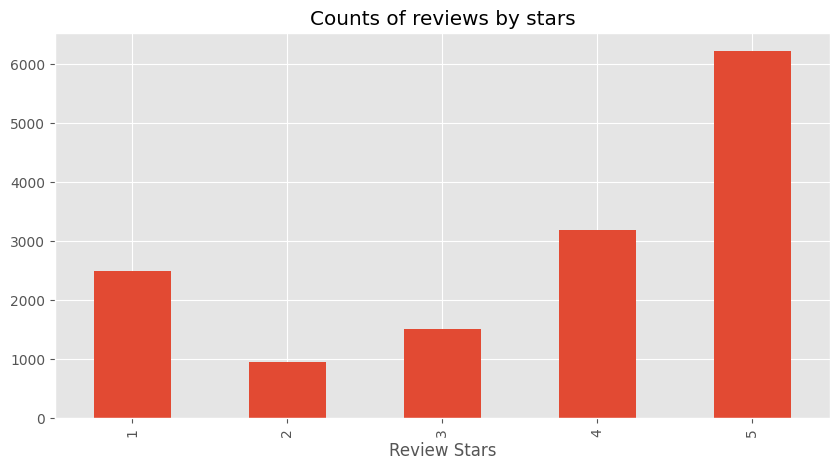

In [4]:
# to indicate how many rating is occupied
ax = data['ReviewStar'].value_counts().sort_index().plot(kind='bar', title= 'Counts of reviews by stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show() # show bar chart

# Pre-Processing

In [5]:
# create pre processing function
def preprocess_data(text):

  # tokenize the text (and make it lowercase)
  tokens = word_tokenize(text.lower())

  # remove stop words
  filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

  # lemmatize the tokens
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  #Join the tokens back into a string
  processed_text = ' '.join(lemmatized_tokens)

  return processed_text


# remove punctuations from data
data['ReviewBody'].dropna(inplace=True)
data['ReviewBody'] = data['ReviewBody'].astype(str) # convert data to 'string' data type

# Preprocess_data
# create a column called 'tokenized'
data['Processed'] = data.apply(lambda x: preprocess_data(x['ReviewBody']), axis=1) # applying the preprocess_data function to the 'COMMENTS' column of  the DataFrame
data # display resulting table

,ReviewTitle,ReviewBody,ReviewStar,Product,Processed
0,Honest review of an edm music lover\r\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...
1,Unreliable earphones with high cost\r\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,"earphone unreliable , bought 15 day meanwhile ..."
2,Really good and durable.\r\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"bought itfor 999 , purchased second time , gif..."
3,stopped working in just 14 days\r\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable . overall good 2 week s...
4,Just Awesome Wireless Headphone under 1000...😉...,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome ... good sound quality & 8-9 hr batter...
...,...,...,...,...,...
14332,Good\r\n,Good\r\n,4,JBL T110BT,good
14333,Amazing Product\r\n,An amazing product but a bit costly.\r\n,5,JBL T110BT,amazing product bit costly .
14334,Not bad\r\n,Sound\r\n,1,JBL T110BT,sound
14335,a good product\r\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long 's good...


# Sentiment Analysis

In [6]:
# creating NLTK sentiment analyzer (via nltk.sentiment.vader library)
analyzer = SentimentIntensityAnalyzer()

# create get_positive_score function
def get_positive_score(text):
    # take text string as input, get sentiment scores pos/neg/neutral (dictionary data type {key:value}) using polarity_scores method
    # polarity score includes score for pos, neg, and neutral (assign sentiment value depending on whether positive score is +ve or - ve, values above 0 classified positive)

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    positive_score = math.ceil(scores['pos']) # ceil() rounds score to the next greater nearest integer. E.g 0.201 round to 1, -0.2 round to 0

    return positive_score

# create get_sentiment function
def get_sentiment(text):

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    sentiment = 1 if scores['pos'] > 0 else 0 # assign sentiment score based on text's POSITIVE score 
   
    return sentiment

 # create new column called 'Positive' and apply get_sentiment function
data['Polarity'] = data['ReviewBody'].apply(get_positive_score)

# create new column called 'sentiment' and apply get_sentiment function
data['Sentiment'] = data['ReviewBody'].apply(get_sentiment) # applying the get_sentiment function to each value in the 'COMMENTS' column (row by row)


data # display table





,ReviewTitle,ReviewBody,ReviewStar,Product,Processed,Polarity,Sentiment
0,Honest review of an edm music lover\r\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...,1,1
1,Unreliable earphones with high cost\r\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,"earphone unreliable , bought 15 day meanwhile ...",1,1
2,Really good and durable.\r\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"bought itfor 999 , purchased second time , gif...",1,1
3,stopped working in just 14 days\r\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable . overall good 2 week s...,1,1
4,Just Awesome Wireless Headphone under 1000...😉...,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome ... good sound quality & 8-9 hr batter...,1,1
...,...,...,...,...,...,...,...
14332,Good\r\n,Good\r\n,4,JBL T110BT,good,1,1
14333,Amazing Product\r\n,An amazing product but a bit costly.\r\n,5,JBL T110BT,amazing product bit costly .,1,1
14334,Not bad\r\n,Sound\r\n,1,JBL T110BT,sound,0,0
14335,a good product\r\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long 's good...,1,1


# Testing

### Confusion Matrix

In [8]:
# check performance of sentiment analyzer

# confusion_matrix is a function evaluates the performance of a classification model by comparing the predicted labels with the actual labels (pass two arguments, data['Positive'] and data['Sentiment'].)
# shows the number of true positives, false positives, true negatives, and false negatives (The rows of the matrix represent the actual labels, while the columns represent the predicted labels)
# diagonal elements of the matrix represent the number of correct predictions, while the off-diagonal elements represent the number of incorrect predictions.

print(confusion_matrix(data['Polarity'], data['Sentiment'])) 
print("_______" * 8)
print(classification_report(data['Polarity'], data['Sentiment']))

[[ 3440     0]
 [    0 10897]]
________________________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3440
           1       1.00      1.00      1.00     10897

    accuracy                           1.00     14337
   macro avg       1.00      1.00      1.00     14337
weighted avg       1.00      1.00      1.00     14337



### Naive Bayes

Encoding to convert from char to numeric and split it into train machine and testing

In [9]:
# train the machine to distinguish the positive and negative rating based on the tokens
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['Sentiment']) # convert to numeric form
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data['Processed'], encoded_labels, stratify = encoded_labels, test_size = 0.3, random_state = 42)

In [10]:
# naive bayes classifier
vector = CountVectorizer(max_features = 600) # features or input (200 means 200 common words are selected)
train_transData = vector.fit_transform(train_sentences) # transform parameter on the training data and transform the input by using learned parameter
test_transData = vector.fit_transform(test_sentences)
# print(train_transData)

Naive = naive_bayes.MultinomialNB()
Naive.fit(train_transData,train_labels)
predictions_NB = Naive.predict(test_transData)

# Use accuracy_score function to get the accuracy

print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, test_labels)*100)
print("Naive Bayes classification report \n", classification_report(test_labels, predictions_NB))


Naive Bayes Accuracy Score ->  75.38354253835425
Naive Bayes classification report 
               precision    recall  f1-score   support

           0       0.41      0.06      0.10      1032
           1       0.77      0.97      0.86      3270

    accuracy                           0.75      4302
   macro avg       0.59      0.52      0.48      4302
weighted avg       0.68      0.75      0.68      4302



### Support Vector Machines (SVM)

In [19]:
# train the machine to distinguish the positive and negative rating based on the tokens
encoder = LabelEncoder()
train_sentences, test_sentences, train_labels, test_labels = model_selection.train_test_split(data['Processed'], data['Sentiment'], test_size = 0.3)
encoded_labels = encoder.fit_transform(data['Sentiment']) # convert to numeric form

In [26]:
np.random.seed(500)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['Processed'])
Train_Sentences_Tfidf = Tfidf_vect.transform(train_sentences)
Test_Sentences_Tfidf = Tfidf_vect.transform(test_sentences)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_Sentences_Tfidf, train_labels)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Train_Sentences_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, train_labels)*100)

print(Tfidf_vect.vocabulary_)
print(Train_Sentences_Tfidf)

SVM Accuracy Score ->  93.81165919282512
{'doubt': 1365, 'great': 1907, 'bass': 584, 'extent': 1597, 'noise': 2749, 'cancellation': 821, 'decent': 1183, 'sound': 4116, 'clarity': 909, 'mindblowing': 2603, 'battery': 605, 'following': 1745, 'dissapointed': 1323, 'though': 4417, 'tried': 4513, 'lot': 2454, 'adjust': 314, 'bluetooth': 698, 'range': 3597, 'pain': 2919, 'ear': 1413, 'due': 1395, 'conical': 1024, 'bud': 766, 'removed': 3707, 'wire': 4784, 'bit': 676, 'long': 2438, 'make': 2504, 'odd': 2794, 'front': 1796, 'pouch': 3193, 'provided': 3428, 'worst': 4858, 'part': 2945, 'low': 2468, 'quality': 3495, 'mic': 2584, 'person': 3035, 'keep': 2314, 'complaining': 992, 'voice': 4693, 'earphone': 1431, 'unreliable': 4594, 'bought': 733, '15': 53, 'day': 1168, 'meanwhile': 2554, 'right': 3782, 'side': 3990, 'got': 1897, 'cracked': 1102, 'automatically': 515, 'divided': 1343, 'two': 4548, 'also': 370, 'much': 2677, 'good': 1867, 'ok': 2808, 'one': 2822, 'thing': 4406, 'boat': 703, 'earphon

### K-Nearest Neighbour (KNN)

Generating synonyms and use similarity scores among texts. Identify the K Nearest Neighbour which has highest similarity score
* using K = 1 (K denotes how many closest neighbours will be used to make prediction)


Explanation:
* Implement a class: KNN_NLC_Classifier(), has functions like 'fit' for training purpose, and 'predict' for predicting purpose on dataset
* KNN uses lazy training (all computation deffered & only starts during prediction)
* In the function 'fit', we assinging dataset to class variables: xtrain and ytrain (no computation needed)
* In the function 'predict' for every row of text data, it compares the text with every row of training data to achieve similarity score ('n' is num of rows of test data)
* Iterate through every row of training data to get similarity score (uses custom function document_similarity that accepts two texts and return a similarity score of 0-1, higher score means more similarity between the texts)


In [11]:
genesis_ic = wn.ic(genesis, False, 0.0)

# KNN_NLC_Classifier class
class KNN_NLC_Classifer():
    # 1. constructor
    def __init__(self, k=1, distance_type = 'path'):
        self.k = k
        self.distance_type = distance_type

    # '2. fit' function used for training
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    # 3. 'predict' function runs the K(1) nearest neighbour algorithm, and return a label with closest match
    def predict(self, x_text):
        self.x_text = x_text
        y_predict = [] # list to store all y_predict values

        x_test_range = range(len(x_test))
        x_train_shape = range(self.x_train.shape[0])

        # loop through each col in each row of test range
        for i in x_test_range:
            max_similarity_score = 0
            max_index = 0 
            for j in x_train_shape:
                temp = self.document_similarity(x_text[i], self.x_train[j]) # temporary variable to store current similarity score at that iteration
                # compare to update max_similarity_score value to store
                if temp > max_similarity_score:
                    max_similarity_score = temp # assign current iteration's similarity score to max_similarity_score
                    max_index = j
            y_predict.append(self.y_train[max_index]) # add in value
        return y_predict

    # 4. implement document similarity function (use synsets - data that are semantically equivalent)
    # convert each document text into synsets (use doc_to_synsets function, returns list of synsets of each token in text data)

    def convert_tag(self, tag) :
        # convert the tag given by nltk.pos_tag to the tag used by wordnet.synsets
        tag_dict = {
            'N' : 'n',
            'J' : 'a',
            'R' : 'r',
            'V' : 'v'
        }

        try:
            return tag_dict[tag[0]]
        except KeyError:
            return None
        
    # 5. this function is inside convert_tag()
    def doc_to_synsets(self, doc):
        # return list of synsets in document (strings to be converted). Tokenize and tag the words in document doc. 
        # find the first synset for each word/tag combination (if synset not found, skipped to next combination)

        tokens = word_tokenize(doc + '') # tokenize sentences in document into separate words
        synsets_list = []

        if (len(tokens) == 1):
            tags = nltk.pos_tag([tokens[0] + ''])
        else:
            tags = nltk.pos_tag(tokens)

        for token, tag in zip(tokens, tags):
            syntag = self.convert_tag(tag[1])
            synsets = wn.synsets(token, syntag)
            if (len(synsets) > 0):
                synsets_list.append(synsets[0])
        return synsets_list

    # 6. Implement 'similarity_score' function, returns score between two texts (use their synsets)
    # distance_type parameter (value can be 'path', 'wup', 'jcn'). Depending on the value, the appropriate similarity method used (from nltk)

    def similarity_score(self, s1, s2, distance_type = 'path'): # s1 and s2 (list of synsets from doc_to_synsets)
        # calculate average similarity score of score1 onto score2.
        # for each synset in s1, find the synset in s2 with larget similarity value
        # find average (total up all the largest similarity values, divide by number of largest similarity values found)

        s1_largest_scores = []

        for i, s1_synset in enumerate(s1, 0):
            max_score = 0 
            for s2_synset in s2:
                if distance_type == 'path':
                    score = s1_synset.path_similarity(s2_synset, simulate_root = False)
                else:
                    score = s1_synset.wup_similarity(s2_synset)
                
                if score != None:
                    if score > max_score:
                        max_score = score
            
            if max_score != 0:
                s1_largest_scores.append(max_score)

        mean_score = np.mean(s1_largest_scores)

        return mean_score

    # 7. implement 'doc_similarity' function' (calculates similarity between document 1 and document 2)
    def document_similarity(self, doc1, doc2):
        # find symmetrical similarity of synsets between document 1 and document 2
        synsets1 = self.doc_to_synsets(doc1)
        synsets2 = self.doc_to_synsets(doc2)

        return (self.similarity_score(synsets1, synsets2) + self.similarity_score(synsets1, synsets2) / 2)

In [12]:
doc1 = 'Hi'
doc2 = 'I like showers'
x = KNN_NLC_Classifer()
print("Test Similarity Score: ", x.document_similarity(doc1, doc2))

# will use dataset later, in progress

Test Similarity Score:  0.16666666666666666
